In [1]:
from utils import *

In [2]:
path_simus = Path('./simus_with_more_shifts')
path_index = path_simus / 'index.parquet'
keys = ['date', 'symbol']

In [3]:
index = pl.scan_parquet(path_index).collect()
len(index)

354

In [4]:
percentiles = [0.99, 0.90, 0.75, 0.50, 0.25, 0.10, 0.01]

# Load train weights

In [5]:
hyperparameters = {'formation_length': 42, 't_max': 10, 'n_stocks': 100}

In [6]:
%%time
weights = read_weights_one_hyperparameter(hyperparameters, path_index).collect()

CPU times: user 2.08 s, sys: 285 ms, total: 2.37 s
Wall time: 286 ms


In [7]:
prop_train = 0.7
prop_valid = 0.15
end_date_train, end_date_valid, end_date = split_train_valid_test(
    weights, keys[0], prop_train, prop_valid
)
end_date_train, end_date_valid, end_date

(datetime.date(2017, 4, 20),
 datetime.date(2020, 9, 18),
 datetime.date(2024, 4, 3))

In [8]:
weights = weights.filter(pl.col(keys[0]) <= end_date_train)
weights.describe()

shape: (9, 4)
┌────────────┬────────────┬────────┬────────────┐
│ statistic  ┆ date       ┆ symbol ┆ weight     │
│ ---        ┆ ---        ┆ ---    ┆ ---        │
│ str        ┆ str        ┆ str    ┆ f64        │
╞════════════╪════════════╪════════╪════════════╡
│ count      ┆ 560678     ┆ 560678 ┆ 16365.0    │
│ null_count ┆ 0          ┆ 0      ┆ 544313.0   │
│ mean       ┆ 2008-11-22 ┆ null   ┆ 0.141263   │
│ std        ┆ null       ┆ null   ┆ 5.718846   │
│ min        ┆ 2000-04-17 ┆ AAL    ┆ -95.26028  │
│ 25%        ┆ 2004-09-10 ┆ null   ┆ -0.294824  │
│ 50%        ┆ 2008-11-17 ┆ null   ┆ -0.002082  │
│ 75%        ┆ 2013-03-19 ┆ null   ┆ 0.255887   │
│ max        ┆ 2017-04-20 ┆ ZION   ┆ 214.289344 │
└────────────┴────────────┴────────┴────────────┘

<Figure size 900x500 with 0 Axes>

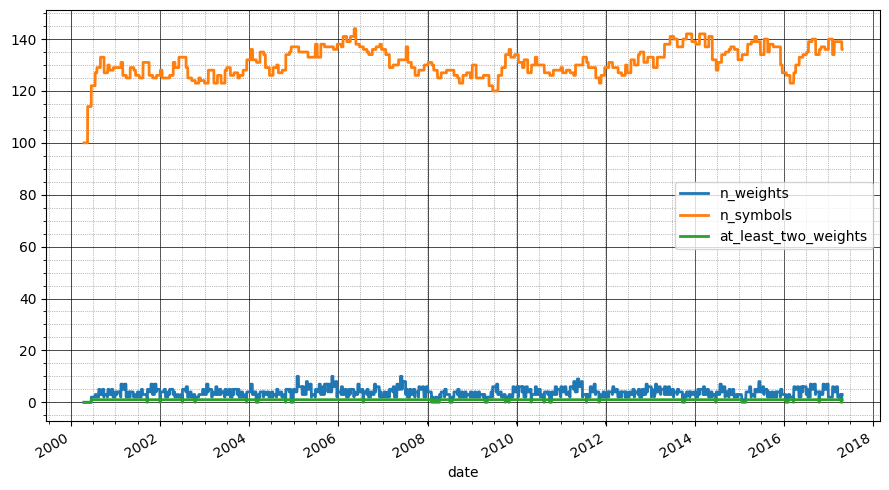

In [9]:
coverage = (
    weights
    .group_by('date')
    .agg([
        pl.col('weight').is_not_null().sum().alias('n_weights'),
        pl.col('symbol').len().alias('n_symbols'),
    ])
    .with_columns(prop=pl.col('n_weights') / pl.col('n_symbols'))
    .with_columns(at_least_two_weights=pl.col('n_weights').ge(2).cast(pl.UInt8))
)
plot_ts(coverage.drop('prop'), 'date')

<Figure size 900x500 with 0 Axes>

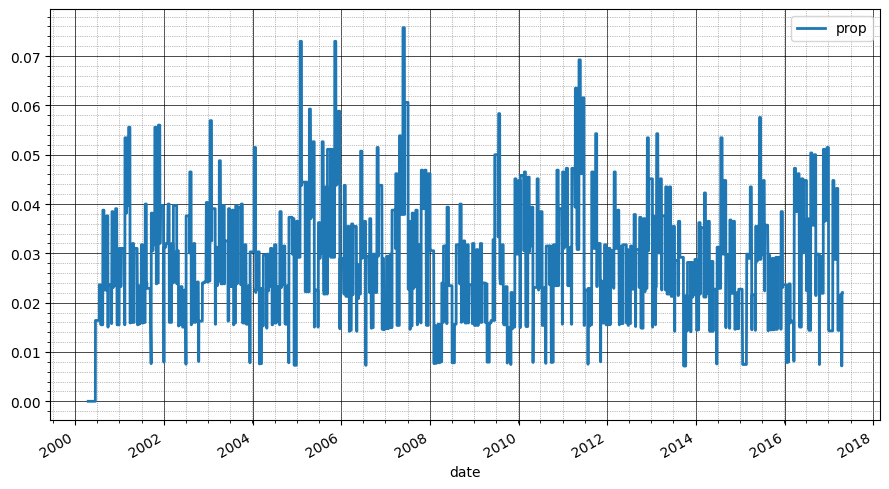

In [10]:
plot_ts(coverage.select('date', 'prop'), 'date')

<Figure size 900x500 with 0 Axes>

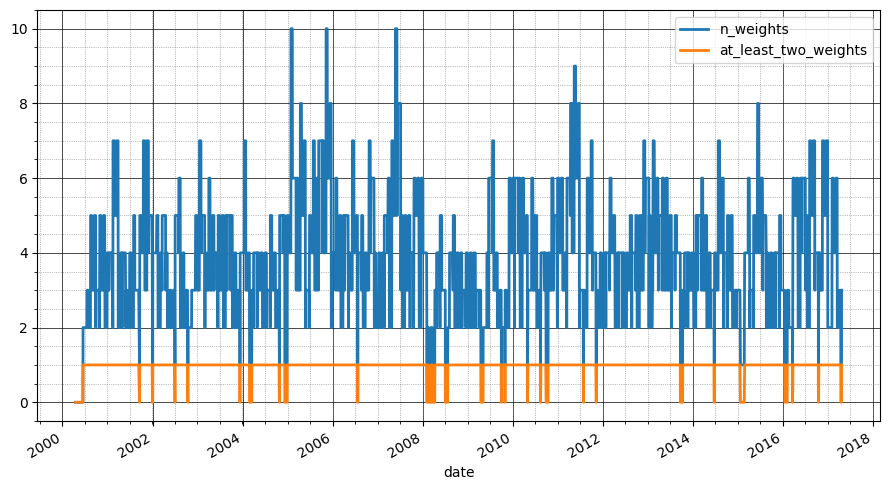

In [11]:
plot_ts(coverage.select('date', 'n_weights', 'at_least_two_weights'), 'date')

# Cross-sectional normalization

## Failed attempt: project_l1_sphere

In [12]:
transposed = (
    pivot_to_pd(weights, keys[1], keys[0], 'weight')
    .to_numpy()
)
transposed.shape

(442, 4279)

In [13]:
%%time
projected = np.apply_along_axis(project_l1_sphere, axis=0, arr=transposed)
projected.shape

CPU times: user 17.3 s, sys: 23.9 ms, total: 17.3 s
Wall time: 17.3 s


(442, 4279)

count    4.279000e+03
mean     8.253869e-01
std      3.190618e-01
min      0.000000e+00
1%       1.356133e-17
10%      2.113301e-01
25%      7.967190e-01
50%      1.000000e+00
75%      1.000000e+00
90%      1.000000e+00
99%      1.000000e+00
max      1.000002e+00
dtype: float64

<Axes: >

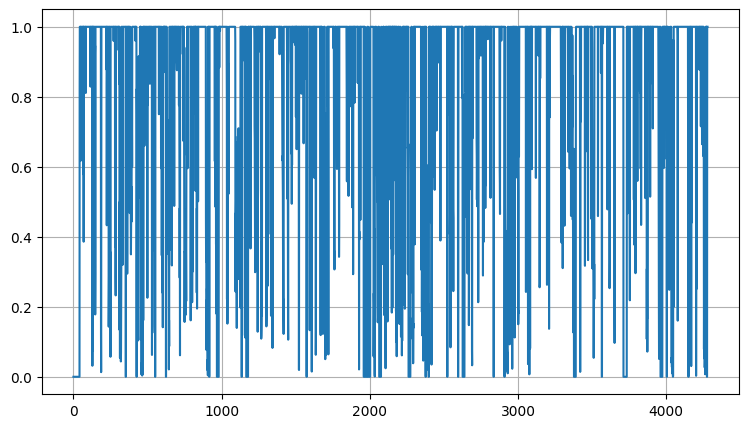

In [14]:
series = pd.Series(np.nansum(np.abs(projected), axis=0))
display(series.describe(percentiles=percentiles))
series.plot(grid=True)

count    4.279000e+03
mean     8.005533e-15
std      3.968560e-13
min     -2.277428e-12
1%      -3.172579e-13
10%     -6.106227e-16
25%     -5.551115e-17
50%      0.000000e+00
75%      5.551115e-17
90%      5.314441e-16
99%      3.200917e-13
max      2.465590e-11
dtype: float64

<Axes: >

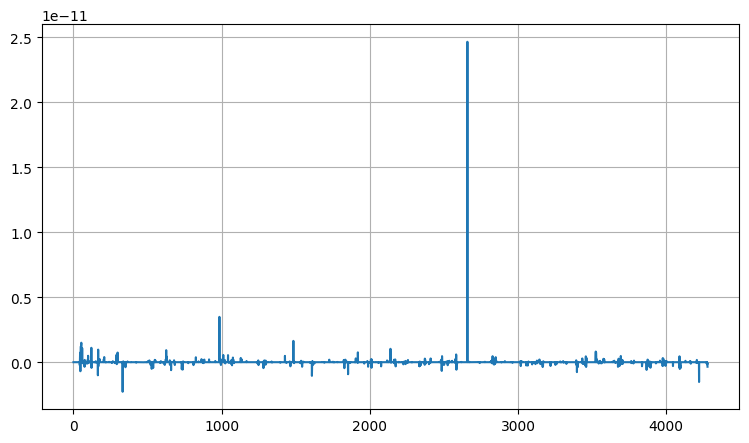

In [15]:
series = pd.Series(np.nansum(projected, axis=0))
display(series.describe(percentiles=percentiles))
series.plot(grid=True)

## Project l1 ball

In [16]:
test = np.array([-0.2, -0.3, 0.5, 0.7, 0.2])
test.sum(), np.abs(test).sum()

(0.8999999999999999, 1.9)

In [17]:
tested = project_l1_sphere(test)
tested.sum(), np.abs(tested).sum(), (tested[tested >= 0]).sum(), (tested[tested <= 0]).sum()

(-4.831851026527049e-17,
 1.0000000045013828,
 0.5000000022506915,
 -0.5000000022506915)

In [18]:
%%time
unstacked = (
    weights
    .pivot(index=keys[1], columns=keys[0], values='weight')
)
projected = np.apply_along_axis(project_lp_ball, axis=0, arr=unstacked.drop(keys[1]).to_numpy())
projected = pl.DataFrame(data=projected, schema=unstacked.columns[1:], nan_to_null=True)

stacked = (
    pl.concat([unstacked.select(keys[1]), projected], how='horizontal')
    .melt(keys[1], variable_name=keys[0], value_name='projected')
    .select(*keys, 'projected')
    .sort(keys)
    .with_columns(pl.col(keys[0]).cast(pl.Date()))
)
assert weights.join(stacked, how='anti', on=keys).is_empty()
joined = weights.join(stacked, on=keys, how='left')
assert have_same_nulls(joined, 'weight', 'projected')
assert joined.shape[0] == weights.shape[0]

CPU times: user 15.5 s, sys: 419 ms, total: 15.9 s
Wall time: 14.1 s


<Figure size 900x500 with 0 Axes>

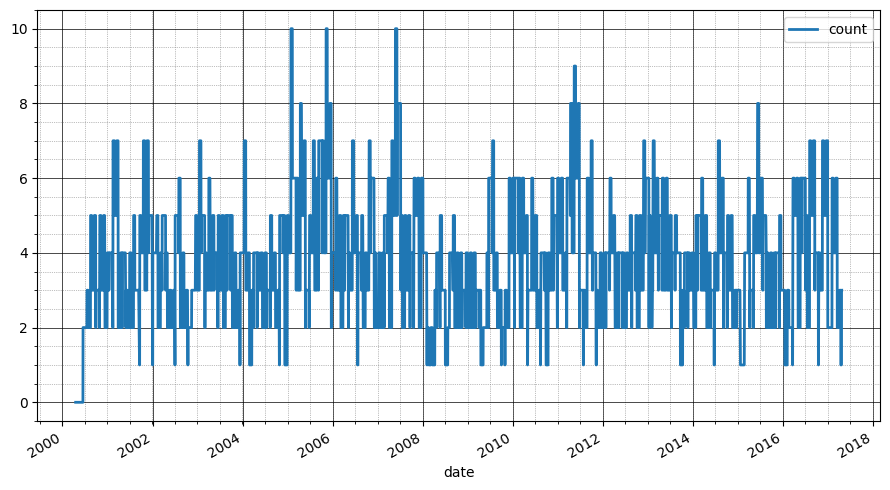

<Figure size 900x500 with 0 Axes>

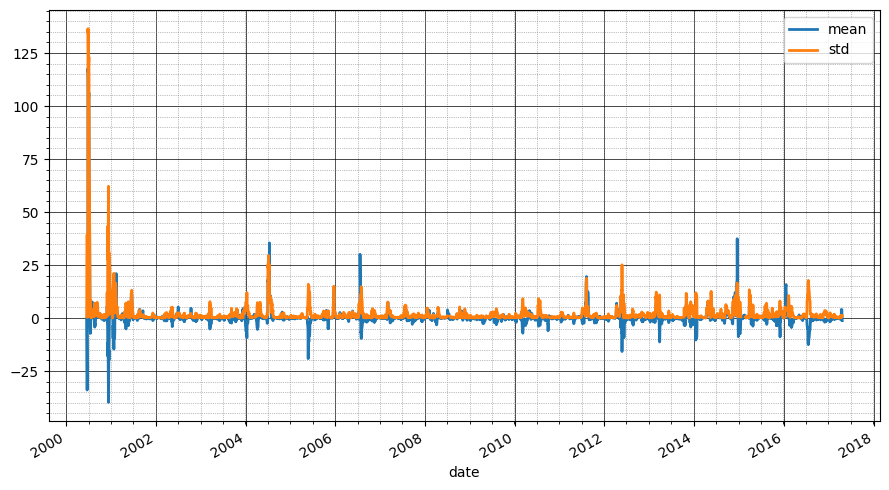

<Figure size 900x500 with 0 Axes>

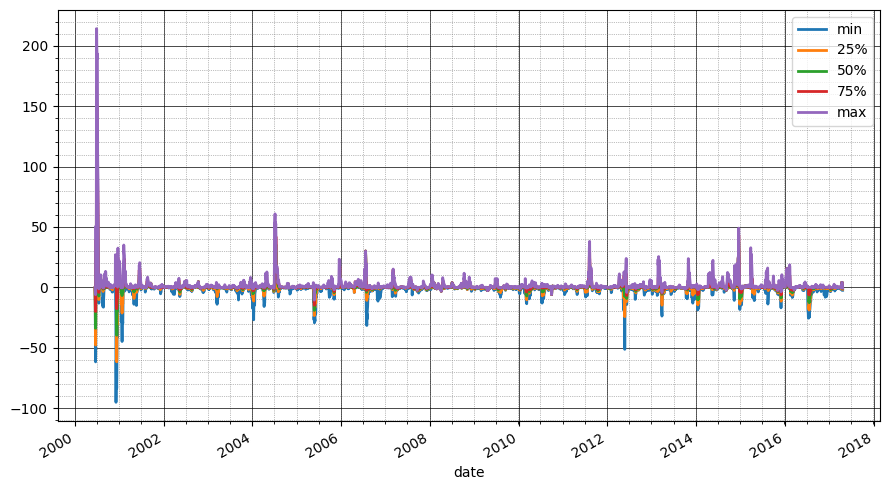

In [19]:
plot_desc_pfo_matrix(pivot_to_pd(joined, *keys, 'weight'))

<Figure size 900x500 with 0 Axes>

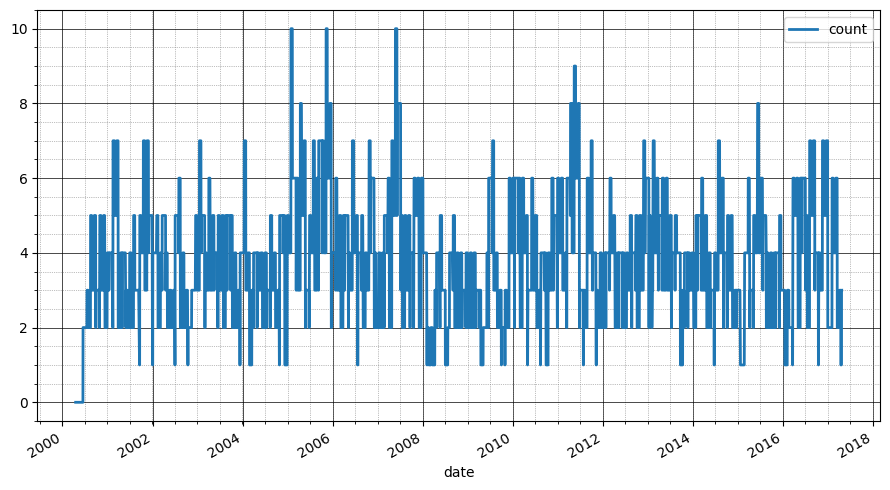

<Figure size 900x500 with 0 Axes>

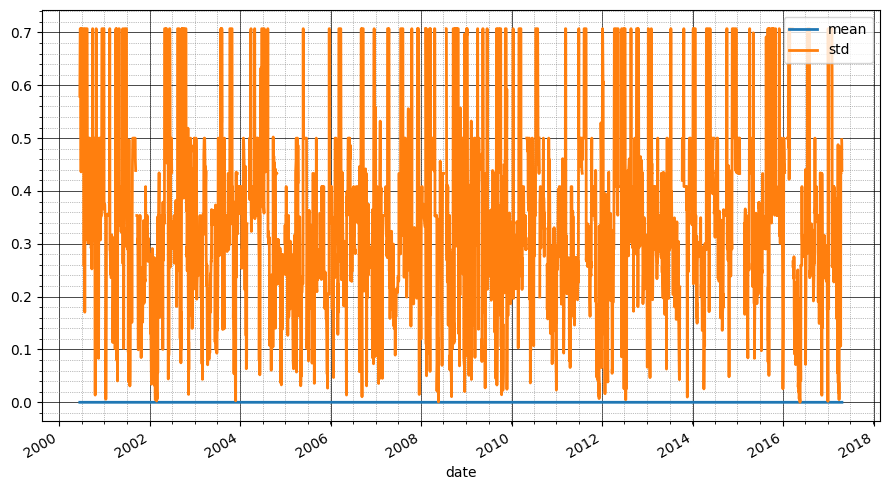

<Figure size 900x500 with 0 Axes>

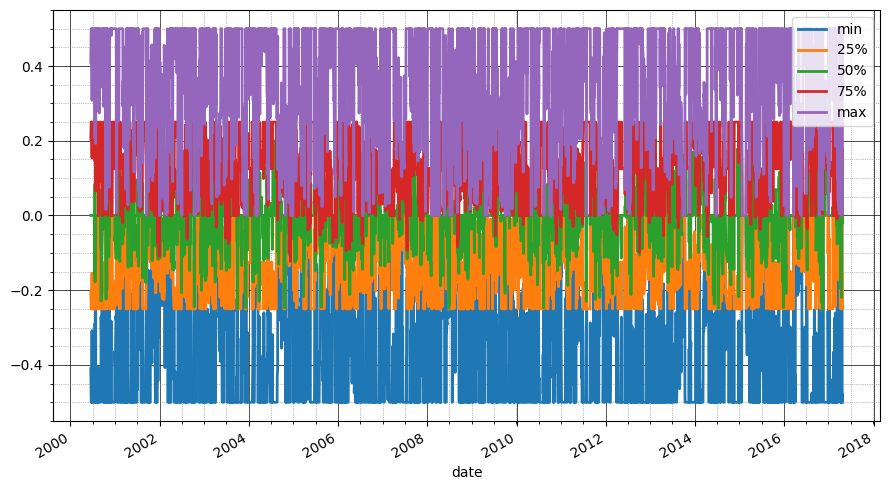

In [20]:
plot_desc_pfo_matrix(pivot_to_pd(joined, *keys, 'projected'))

<Figure size 900x500 with 0 Axes>

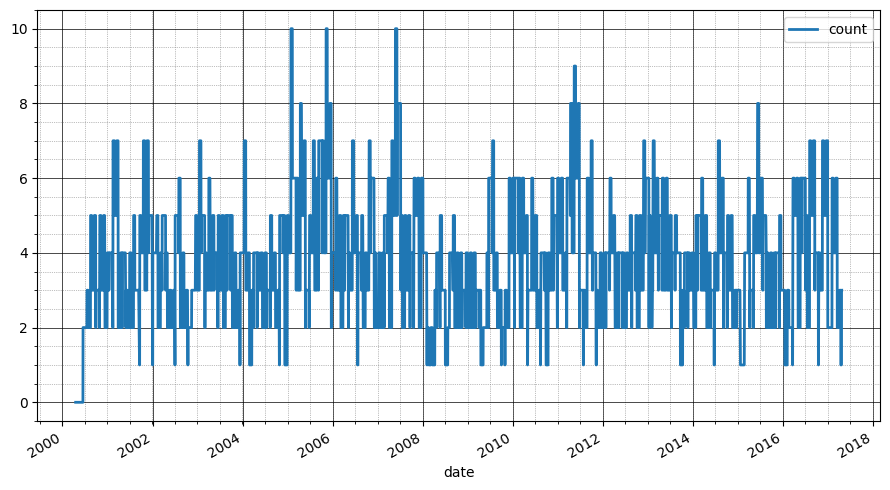

<Figure size 900x500 with 0 Axes>

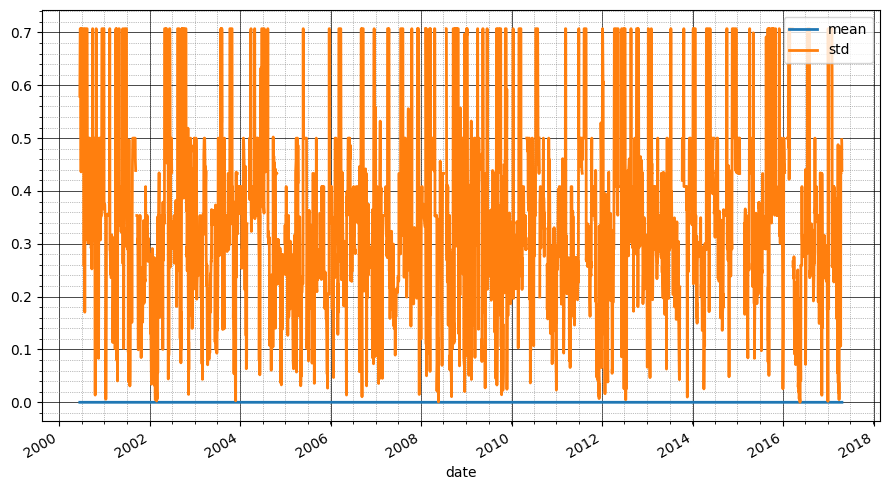

<Figure size 900x500 with 0 Axes>

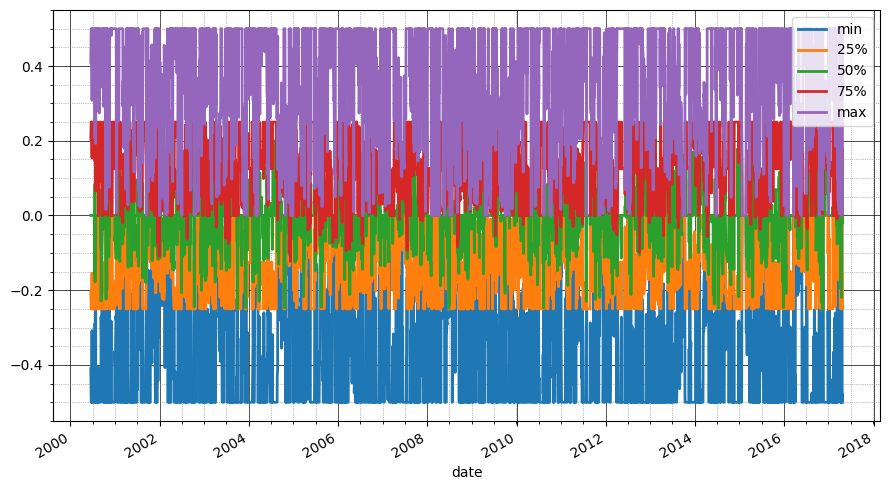

In [21]:
joined = get_leverage_one(joined, keys[0], 'projected')
plot_desc_pfo_matrix(pivot_to_pd(joined, *keys, 'projected'))

In [22]:
%%time
projected_weights = project_l1_ball_pl(weights, keys[0], 'weight')

CPU times: user 15.4 s, sys: 320 ms, total: 15.7 s
Wall time: 14.4 s


<Figure size 900x500 with 0 Axes>

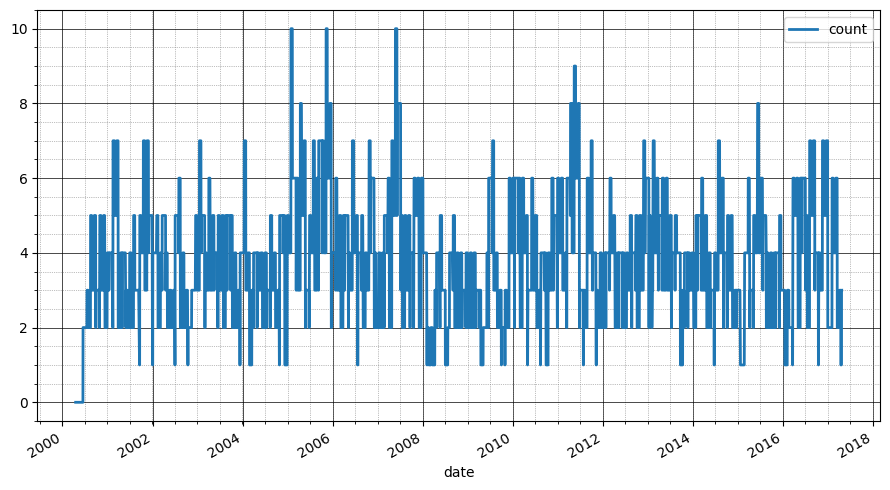

<Figure size 900x500 with 0 Axes>

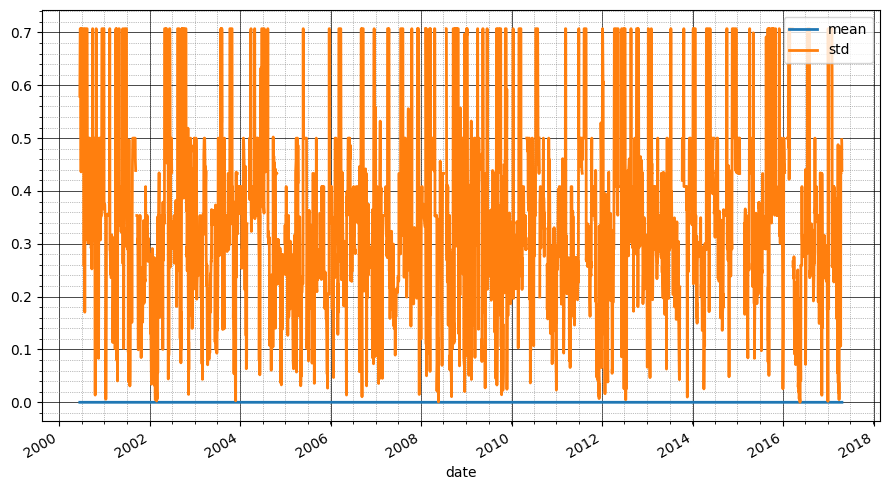

<Figure size 900x500 with 0 Axes>

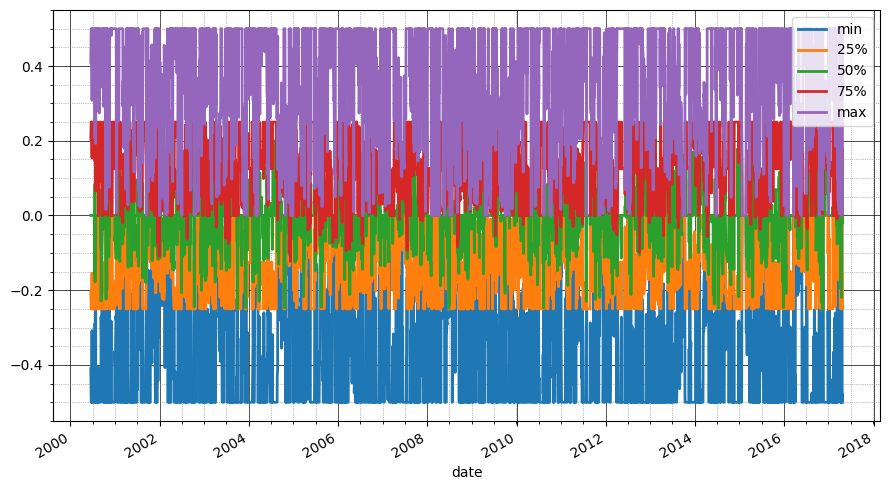

In [23]:
plot_desc_pfo_matrix(pivot_to_pd(projected_weights, *keys, 'projected'))

<Figure size 900x500 with 0 Axes>

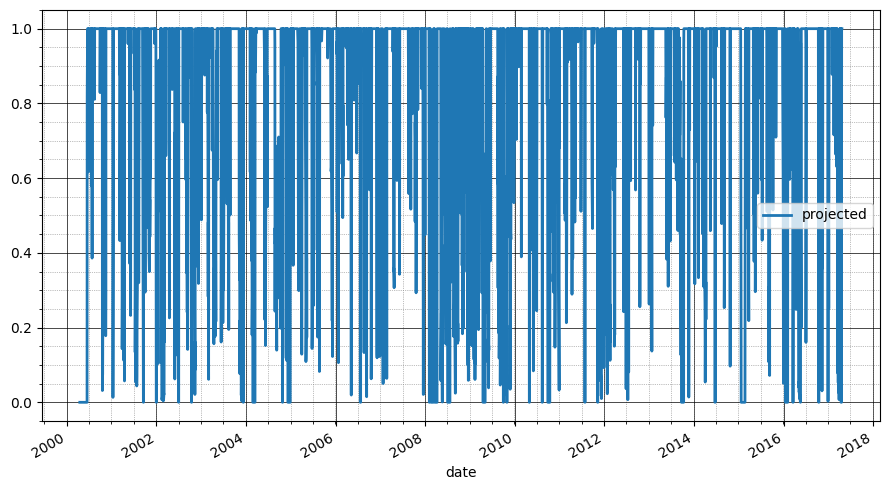

In [24]:
leverage = projected_weights.group_by(keys[0], maintain_order=True).agg(pl.col('projected').abs().sum())
plot_ts(leverage, 'date')

## Second attempt to project on the sphere

In [25]:
# renamed = projected_weights.drop('weight').rename({'projected': 'weight'})
# projected_projected_weights = project_l1_sphere_pl(renamed, keys[0], 'weight')

In [26]:
# plot_desc_pfo_matrix(pivot_to_pd(projected_projected_weights, *keys, 'projected'))

In [27]:
# leverage = projected_projected_weights.group_by(keys[0], maintain_order=True).agg(pl.col('projected').abs().sum())
# plot_ts(leverage, 'date')

## Cross-sectional scale, standard

shape: (13, 7)
┌────────────┬────────────┬────────┬────────────┬────────────┬────────────┬───────────┐
│ statistic  ┆ date       ┆ symbol ┆ weight     ┆ mean       ┆ std        ┆ standard  │
│ ---        ┆ ---        ┆ ---    ┆ ---        ┆ ---        ┆ ---        ┆ ---       │
│ str        ┆ str        ┆ str    ┆ f64        ┆ f64        ┆ f64        ┆ f64       │
╞════════════╪════════════╪════════╪════════════╪════════════╪════════════╪═══════════╡
│ count      ┆ 560678     ┆ 560678 ┆ 16365.0    ┆ 556184.0   ┆ 533241.0   ┆ 16189.0   │
│ null_count ┆ 0          ┆ 0      ┆ 544313.0   ┆ 4494.0     ┆ 27437.0    ┆ 544489.0  │
│ mean       ┆ 2008-11-22 ┆ null   ┆ 0.141263   ┆ 0.292399   ┆ 2.023908   ┆ 0.0       │
│ std        ┆ null       ┆ null   ┆ 5.718846   ┆ 5.354932   ┆ 6.156146   ┆ 0.865562  │
│ min        ┆ 2000-04-17 ┆ AAL    ┆ -95.26028  ┆ -39.753191 ┆ 0.000016   ┆ -2.512468 │
│ …          ┆ …          ┆ …      ┆ …          ┆ …          ┆ …          ┆ …         │
│ 50%        ┆ 2008-11-17 ┆ null   ┆ -0.002082  ┆ -0.016428  ┆ 0.734481   ┆ 0.021807  │
│ 75%        ┆ 2013-03-19 ┆ null   ┆ 0.255887   ┆ 0.473238   ┆ 1.78583    ┆ 0.666213  │
│ 90%        ┆ 2015-08-24 ┆ null   ┆ 1.151386   ┆ 1.806433   ┆ 4.400314   ┆ 1.102245  │
│ 99%        ┆ 2017-02-22 ┆ null   ┆ 12.83693   ┆ 11.842563  ┆ 16.121866  ┆ 1.877697  │
│ max        ┆ 2017-04-20 ┆ ZION   ┆ 214.289344 ┆ 117.786952 ┆ 136.474991 ┆ 2.835973  │
└────────────┴────────────┴────────┴────────────┴────────────┴────────────┴───────────┘

<Figure size 900x500 with 0 Axes>

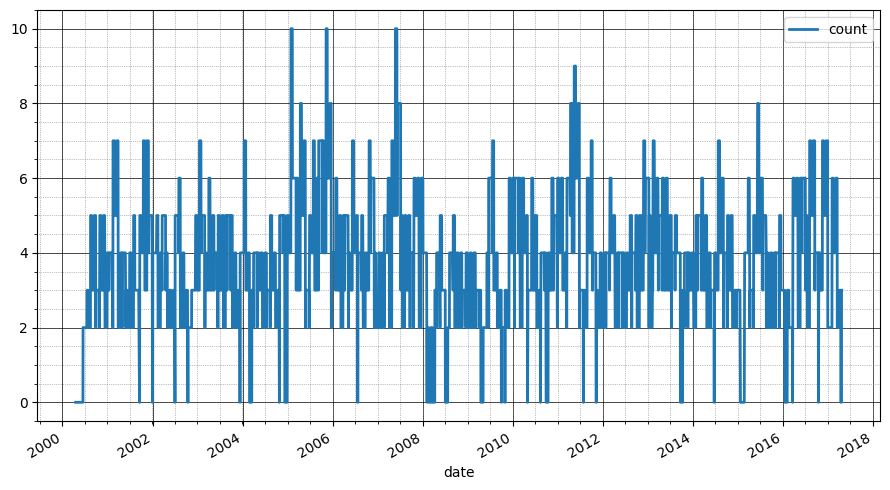

<Figure size 900x500 with 0 Axes>

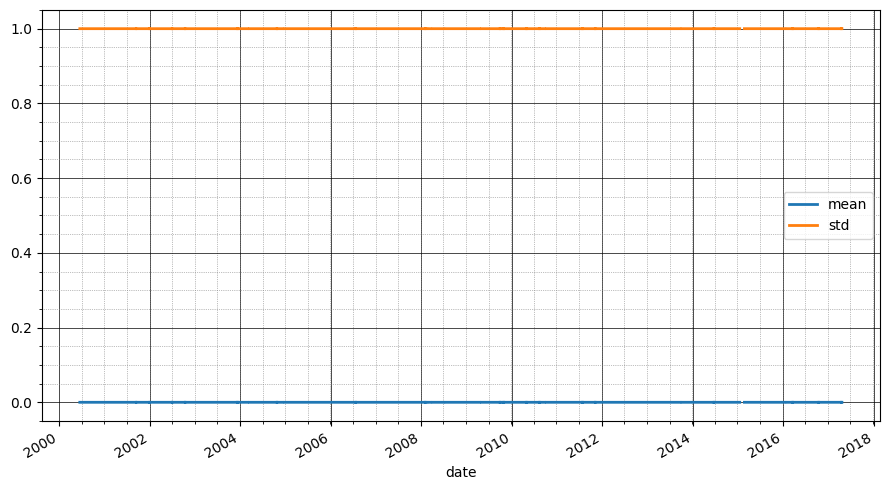

<Figure size 900x500 with 0 Axes>

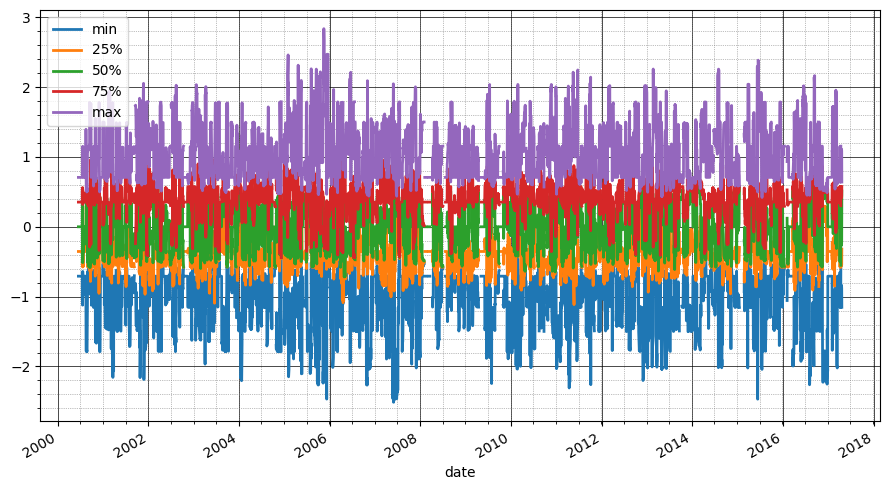

In [28]:
scaled = standard_scale(weights, keys[0], 'weight')
display(scaled.describe(percentiles=percentiles))
sub = pivot_to_pd(scaled, *keys, 'standard')
plot_desc_pfo_matrix(sub)

<Axes: xlabel='date'>

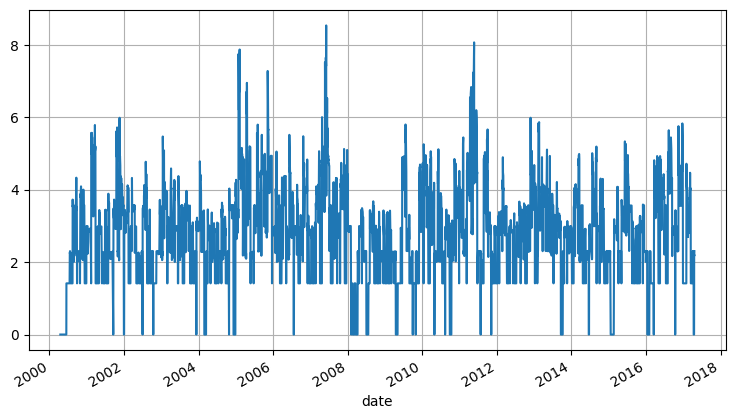

In [29]:
sub.abs().sum(axis=1).plot(grid=True)

## Cross-sectional scale, robust

shape: (13, 8)
┌────────────┬────────────┬────────┬────────────┬────────────┬────────────┬────────────┬───────────┐
│ statistic  ┆ date       ┆ symbol ┆ weight     ┆ median     ┆ low        ┆ high       ┆ robust    │
│ ---        ┆ ---        ┆ ---    ┆ ---        ┆ ---        ┆ ---        ┆ ---        ┆ ---       │
│ str        ┆ str        ┆ str    ┆ f64        ┆ f64        ┆ f64        ┆ f64        ┆ f64       │
╞════════════╪════════════╪════════╪════════════╪════════════╪════════════╪════════════╪═══════════╡
│ count      ┆ 560678     ┆ 560678 ┆ 16365.0    ┆ 556184.0   ┆ 556184.0   ┆ 556184.0   ┆ 16189.0   │
│ null_count ┆ 0          ┆ 0      ┆ 544313.0   ┆ 4494.0     ┆ 4494.0     ┆ 4494.0     ┆ 544489.0  │
│ mean       ┆ 2008-11-22 ┆ null   ┆ 0.141263   ┆ 0.321791   ┆ -0.364802  ┆ 1.299356   ┆ -1.27859  │
│ std        ┆ null       ┆ null   ┆ 5.718846   ┆ 5.215094   ┆ 3.591907   ┆ 8.681138   ┆ 180.58342 │
│            ┆            ┆        ┆            ┆            ┆            ┆            ┆ 5         │
│ min        ┆ 2000-04-17 ┆ AAL    ┆ -95.26028  ┆ -39.753191 ┆ -83.708266 ┆ -10.625614 ┆ -20719.78 │
│            ┆            ┆        ┆            ┆            ┆            ┆            ┆ 6959      │
│ …          ┆ …          ┆ …      ┆ …          ┆ …          ┆ …          ┆ …          ┆ …         │
│ 50%        ┆ 2008-11-17 ┆ null   ┆ -0.002082  ┆ -0.003575  ┆ -0.060285  ┆ 0.107858   ┆ 0.0       │
│ 75%        ┆ 2013-03-19 ┆ null   ┆ 0.255887   ┆ 0.22325    ┆ 0.06249    ┆ 0.707798   ┆ 0.5       │
│ 90%        ┆ 2015-08-24 ┆ null   ┆ 1.151386   ┆ 1.006955   ┆ 0.545351   ┆ 2.496538   ┆ 1.036198  │
│ 99%        ┆ 2017-02-22 ┆ null   ┆ 12.83693   ┆ 12.111209  ┆ 8.45601    ┆ 19.241431  ┆ 22.001908 │
│ max        ┆ 2017-04-20 ┆ ZION   ┆ 214.289344 ┆ 117.786952 ┆ 30.045447  ┆ 214.289344 ┆ 4754.9145 │
│            ┆            ┆        ┆            ┆            ┆            ┆            ┆ 91        │
└────────────┴────────────┴────────┴────────────┴────────────┴────────────┴────────────┴───────────┘

<Figure size 900x500 with 0 Axes>

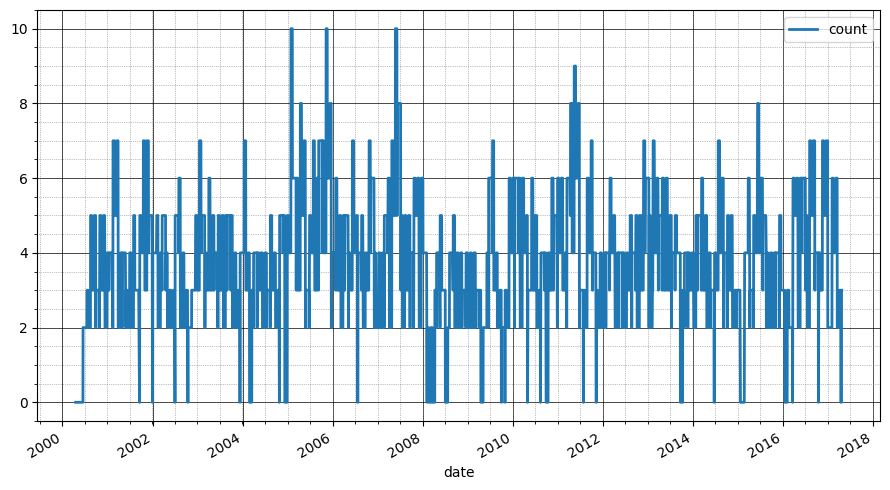

<Figure size 900x500 with 0 Axes>

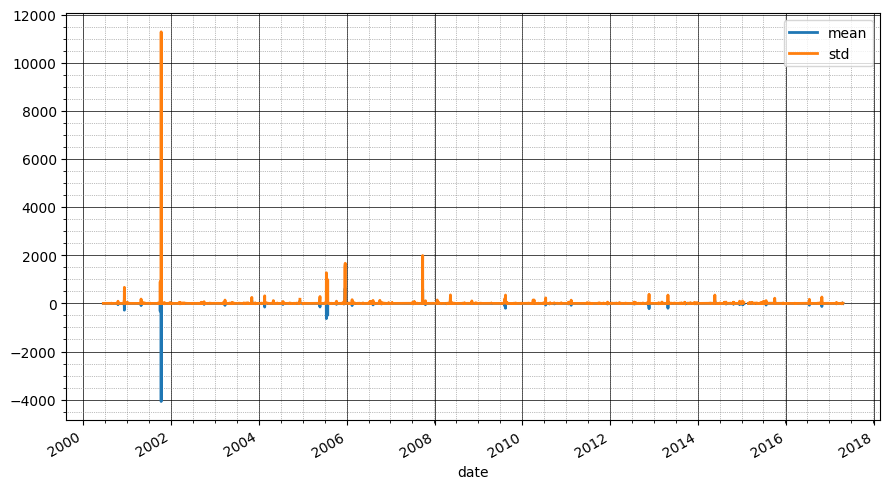

<Figure size 900x500 with 0 Axes>

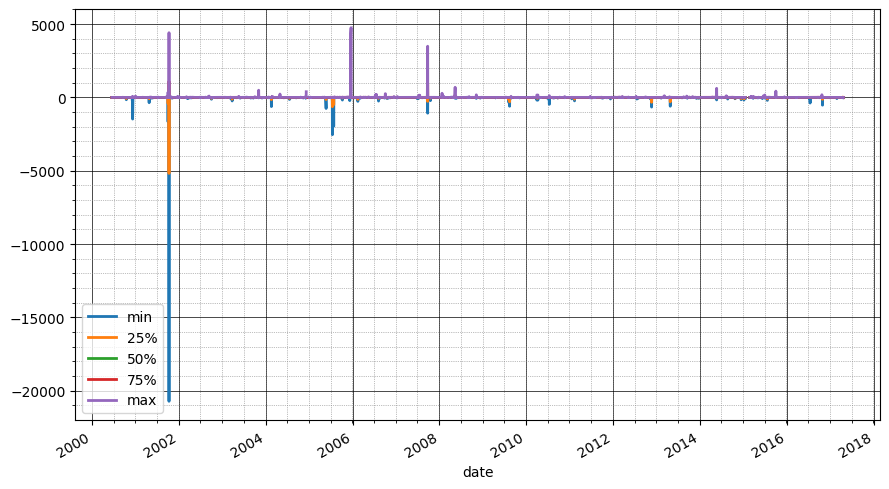

In [30]:
scaled = robust_scale(weights, keys[0], 'weight')
display(scaled.describe(percentiles=percentiles))
sub = pivot_to_pd(scaled, *keys, 'robust')
plot_desc_pfo_matrix(sub)

<Axes: xlabel='date'>

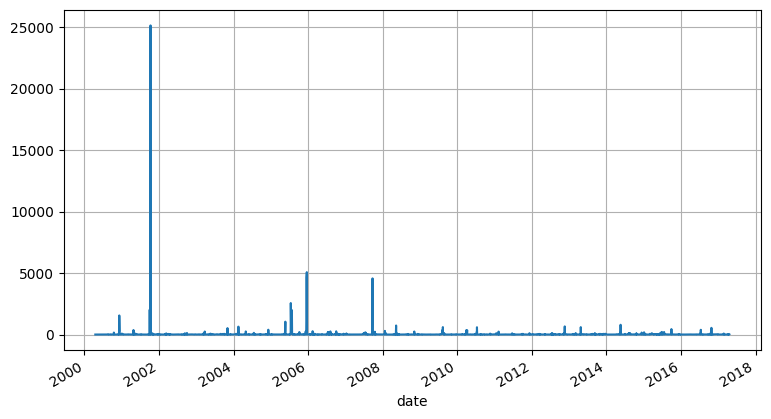

In [31]:
sub.abs().sum(axis=1).plot(grid=True)

## Cross-sectional scale, rank

shape: (13, 7)
┌────────────┬────────────┬────────┬────────────┬──────────┬──────────┬──────────┐
│ statistic  ┆ date       ┆ symbol ┆ weight     ┆ rank     ┆ rank_max ┆ uniform  │
│ ---        ┆ ---        ┆ ---    ┆ ---        ┆ ---      ┆ ---      ┆ ---      │
│ str        ┆ str        ┆ str    ┆ f64        ┆ f64      ┆ f64      ┆ f64      │
╞════════════╪════════════╪════════╪════════════╪══════════╪══════════╪══════════╡
│ count      ┆ 560678     ┆ 560678 ┆ 16365.0    ┆ 16365.0  ┆ 556184.0 ┆ 16365.0  │
│ null_count ┆ 0          ┆ 0      ┆ 544313.0   ┆ 544313.0 ┆ 4494.0   ┆ 544313.0 │
│ mean       ┆ 2008-11-22 ┆ null   ┆ 0.141263   ┆ 2.786557 ┆ 3.871884 ┆ NaN      │
│ std        ┆ null       ┆ null   ┆ 5.718846   ┆ 1.625306 ┆ 1.658977 ┆ NaN      │
│ min        ┆ 2000-04-17 ┆ AAL    ┆ -95.26028  ┆ 1.0      ┆ 1.0      ┆ -0.5     │
│ …          ┆ …          ┆ …      ┆ …          ┆ …        ┆ …        ┆ …        │
│ 50%        ┆ 2008-11-17 ┆ null   ┆ -0.002082  ┆ 2.0      ┆ 4.0      ┆ 0.0      │
│ 75%        ┆ 2013-03-19 ┆ null   ┆ 0.255887   ┆ 4.0      ┆ 5.0      ┆ 0.25     │
│ 90%        ┆ 2015-08-24 ┆ null   ┆ 1.151386   ┆ 5.0      ┆ 6.0      ┆ 0.5      │
│ 99%        ┆ 2017-02-22 ┆ null   ┆ 12.83693   ┆ 7.0      ┆ 8.0      ┆ NaN      │
│ max        ┆ 2017-04-20 ┆ ZION   ┆ 214.289344 ┆ 10.0     ┆ 10.0     ┆ NaN      │
└────────────┴────────────┴────────┴────────────┴──────────┴──────────┴──────────┘

<Figure size 900x500 with 0 Axes>

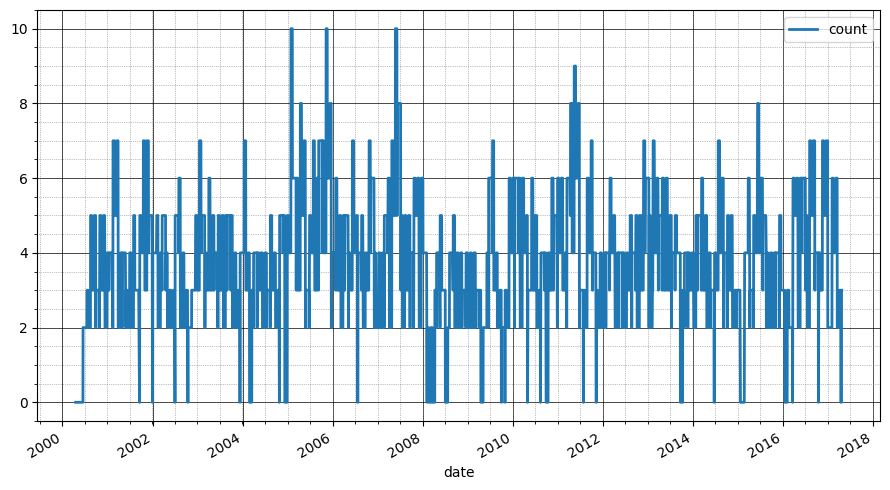

<Figure size 900x500 with 0 Axes>

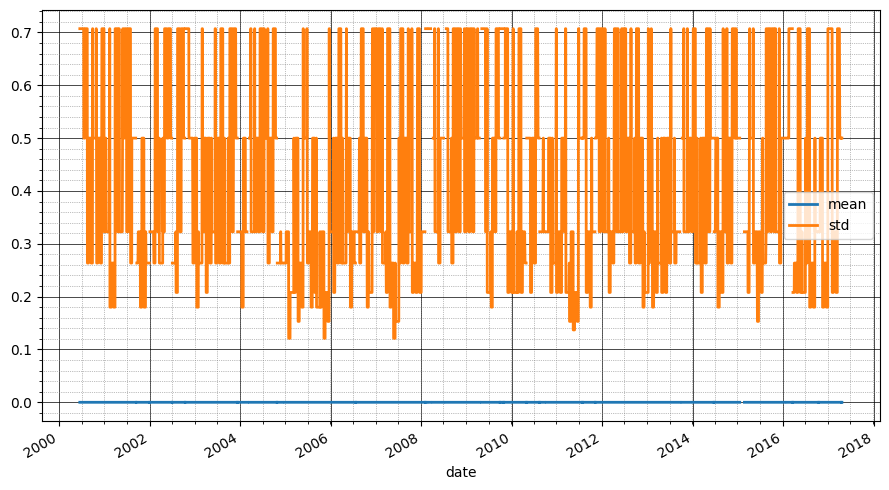

<Figure size 900x500 with 0 Axes>

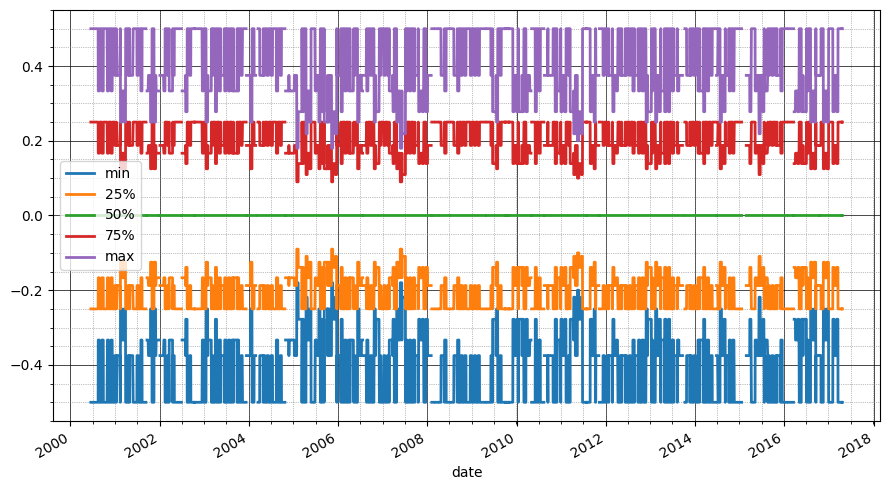

In [32]:
scaled = rank_scale(weights, keys[0], 'weight')
display(scaled.describe(percentiles=percentiles))
sub = pivot_to_pd(scaled, *keys, 'uniform')
plot_desc_pfo_matrix(sub)

<Axes: xlabel='date'>

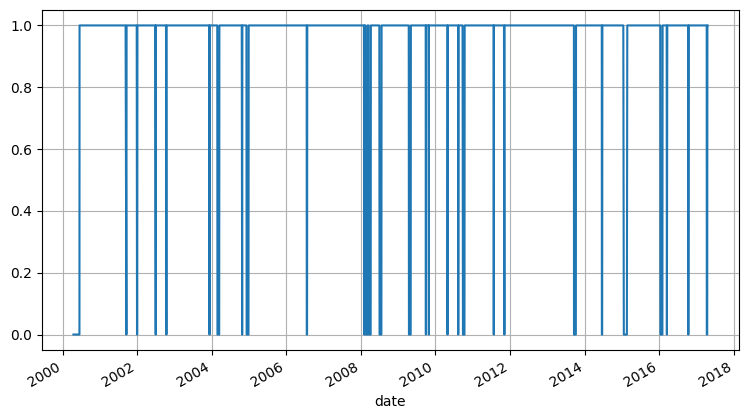

In [33]:
sub.abs().sum(axis=1).plot(grid=True)

# Timeseries smoothing

shape: (13, 5)
┌────────────┬────────────┬────────┬────────────┬────────────┐
│ statistic  ┆ date       ┆ symbol ┆ weight     ┆ smoothed   │
│ ---        ┆ ---        ┆ ---    ┆ ---        ┆ ---        │
│ str        ┆ str        ┆ str    ┆ f64        ┆ f64        │
╞════════════╪════════════╪════════╪════════════╪════════════╡
│ count      ┆ 560678     ┆ 560678 ┆ 16365.0    ┆ 76616.0    │
│ null_count ┆ 0          ┆ 0      ┆ 544313.0   ┆ 484062.0   │
│ mean       ┆ 2008-11-22 ┆ null   ┆ 0.141263   ┆ 0.030175   │
│ std        ┆ null       ┆ null   ┆ 5.718846   ┆ 1.189903   │
│ min        ┆ 2000-04-17 ┆ AAL    ┆ -95.26028  ┆ -19.052056 │
│ …          ┆ …          ┆ …      ┆ …          ┆ …          │
│ 50%        ┆ 2008-11-17 ┆ null   ┆ -0.002082  ┆ -0.000502  │
│ 75%        ┆ 2013-03-19 ┆ null   ┆ 0.255887   ┆ 0.055822   │
│ 90%        ┆ 2015-08-24 ┆ null   ┆ 1.151386   ┆ 0.246533   │
│ 99%        ┆ 2017-02-22 ┆ null   ┆ 12.83693   ┆ 2.840786   │
│ max        ┆ 2017-04-20 ┆ ZION   ┆ 214.289344 ┆ 42.857869  │
└────────────┴────────────┴────────┴────────────┴────────────┘

<Figure size 900x500 with 0 Axes>

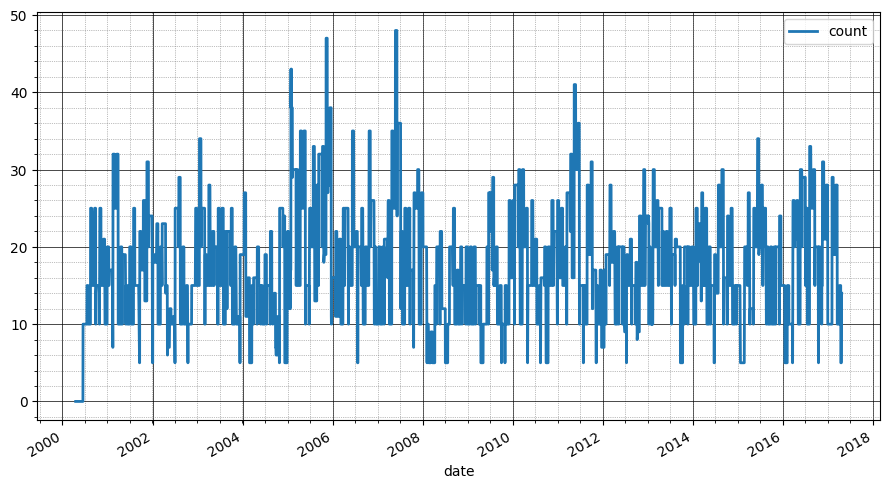

<Figure size 900x500 with 0 Axes>

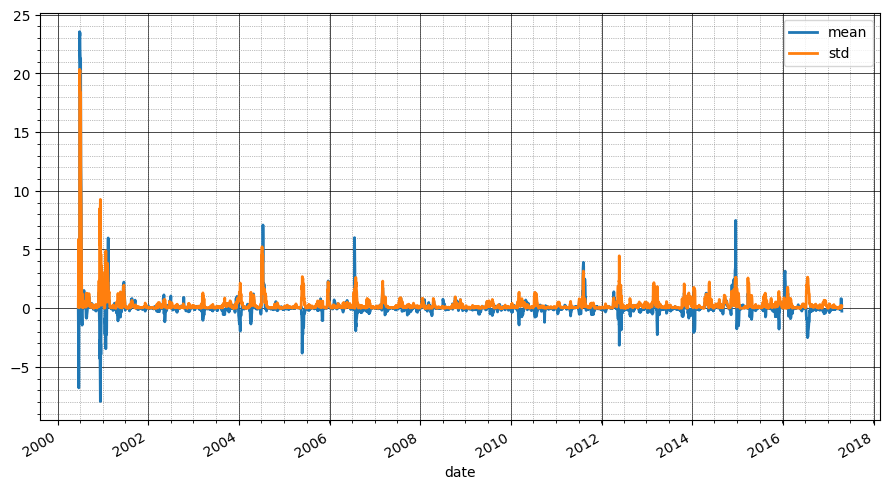

<Figure size 900x500 with 0 Axes>

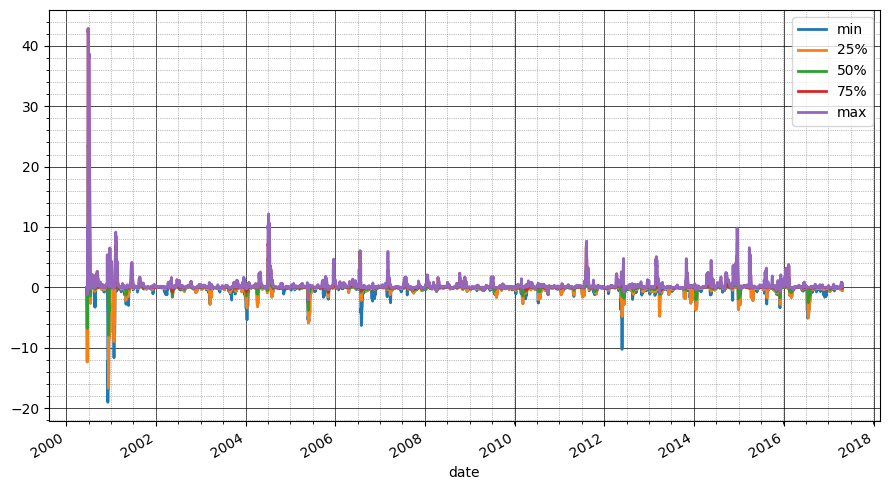

In [34]:
window_size = 5
smoothed = (
    weights
    .with_columns(
        smoothed=pl.col('weight').fill_null(0.0)
        .rolling_mean(window_size=window_size).alias('smoothed')
    )
    .with_columns(pl.when(pl.col('smoothed').abs().ge(1e-5)).then(pl.col('smoothed')).otherwise(None))
)
display(smoothed.describe(percentiles=percentiles))
sub = pivot_to_pd(smoothed, *keys, 'smoothed')
plot_desc_pfo_matrix(sub)

# Do it in some order

In [35]:
# 'leverage_one'
normalized = get_leverage_one(weights, keys[0], 'weight')
normalized.head()

shape: (5, 4)
┌────────────┬────────┬────────┬──────────────┐
│ date       ┆ symbol ┆ weight ┆ leverage_one │
│ ---        ┆ ---    ┆ ---    ┆ ---          │
│ date       ┆ str    ┆ f64    ┆ f64          │
╞════════════╪════════╪════════╪══════════════╡
│ 2000-04-17 ┆ AAPL   ┆ null   ┆ null         │
│ 2000-04-17 ┆ ADBE   ┆ null   ┆ null         │
│ 2000-04-17 ┆ ADI    ┆ null   ┆ null         │
│ 2000-04-17 ┆ ADP    ┆ null   ┆ null         │
│ 2000-04-17 ┆ ADSK   ┆ null   ┆ null         │
└────────────┴────────┴────────┴──────────────┘

<Figure size 900x500 with 0 Axes>

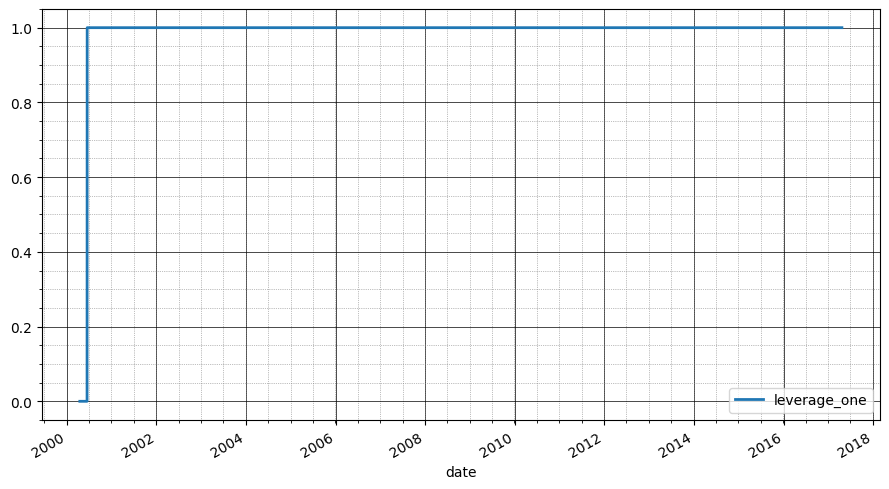

In [36]:
plot_ts(normalized.group_by(keys[0], maintain_order=True).agg(pl.col('leverage_one').abs().sum()), 'date')

In [37]:
# 'mean_zero'
normalized = get_mean_zero(weights, keys[0], 'weight')
normalized.head()

shape: (5, 4)
┌────────────┬────────┬────────┬───────────┐
│ date       ┆ symbol ┆ weight ┆ mean_zero │
│ ---        ┆ ---    ┆ ---    ┆ ---       │
│ date       ┆ str    ┆ f64    ┆ f64       │
╞════════════╪════════╪════════╪═══════════╡
│ 2000-04-17 ┆ AAPL   ┆ null   ┆ null      │
│ 2000-04-17 ┆ ADBE   ┆ null   ┆ null      │
│ 2000-04-17 ┆ ADI    ┆ null   ┆ null      │
│ 2000-04-17 ┆ ADP    ┆ null   ┆ null      │
│ 2000-04-17 ┆ ADSK   ┆ null   ┆ null      │
└────────────┴────────┴────────┴───────────┘

<Figure size 900x500 with 0 Axes>

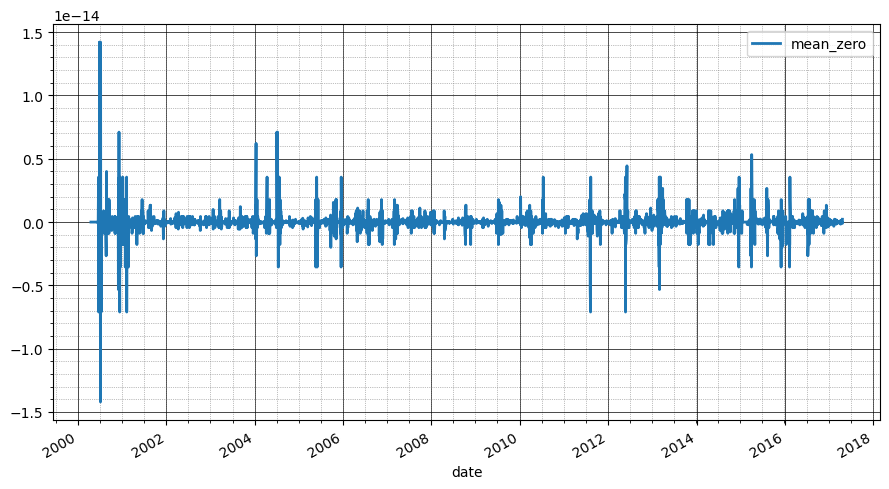

In [38]:
plot_ts(normalized.group_by(keys[0], maintain_order=True).agg(pl.col('mean_zero').sum()), 'date')

In [39]:
%%time
# 'projected'
projected = project_l1_ball_pl(weights, keys[0], 'weight')
projected.tail()

CPU times: user 15.6 s, sys: 264 ms, total: 15.9 s
Wall time: 14.4 s


shape: (5, 4)
┌────────────┬────────┬───────────┬───────────┐
│ date       ┆ symbol ┆ weight    ┆ projected │
│ ---        ┆ ---    ┆ ---       ┆ ---       │
│ date       ┆ str    ┆ f64       ┆ f64       │
╞════════════╪════════╪═══════════╪═══════════╡
│ 2017-04-20 ┆ WDAY   ┆ null      ┆ null      │
│ 2017-04-20 ┆ WDC    ┆ -0.546467 ┆ 0.31911   │
│ 2017-04-20 ┆ WTW    ┆ null      ┆ null      │
│ 2017-04-20 ┆ WYNN   ┆ null      ┆ null      │
│ 2017-04-20 ┆ YY     ┆ null      ┆ null      │
└────────────┴────────┴───────────┴───────────┘

In [40]:
# 'standard'
scaled = standard_scale(weights, keys[0], 'weight')
scaled.tail()

shape: (5, 6)
┌────────────┬────────┬───────────┬───────────┬──────────┬──────────┐
│ date       ┆ symbol ┆ weight    ┆ mean      ┆ std      ┆ standard │
│ ---        ┆ ---    ┆ ---       ┆ ---       ┆ ---      ┆ ---      │
│ date       ┆ str    ┆ f64       ┆ f64       ┆ f64      ┆ f64      │
╞════════════╪════════╪═══════════╪═══════════╪══════════╪══════════╡
│ 2017-04-20 ┆ WDAY   ┆ null      ┆ -1.232328 ┆ 1.070361 ┆ null     │
│ 2017-04-20 ┆ WDC    ┆ -0.546467 ┆ -1.232328 ┆ 1.070361 ┆ 0.640776 │
│ 2017-04-20 ┆ WTW    ┆ null      ┆ -1.232328 ┆ 1.070361 ┆ null     │
│ 2017-04-20 ┆ WYNN   ┆ null      ┆ -1.232328 ┆ 1.070361 ┆ null     │
│ 2017-04-20 ┆ YY     ┆ null      ┆ -1.232328 ┆ 1.070361 ┆ null     │
└────────────┴────────┴───────────┴───────────┴──────────┴──────────┘

In [41]:
# 'robust'
scaled = robust_scale(weights, keys[0], 'weight')
scaled.tail()

shape: (5, 7)
┌────────────┬────────┬───────────┬───────────┬───────────┬───────────┬────────┐
│ date       ┆ symbol ┆ weight    ┆ median    ┆ low       ┆ high      ┆ robust │
│ ---        ┆ ---    ┆ ---       ┆ ---       ┆ ---       ┆ ---       ┆ ---    │
│ date       ┆ str    ┆ f64       ┆ f64       ┆ f64       ┆ f64       ┆ f64    │
╞════════════╪════════╪═══════════╪═══════════╪═══════════╪═══════════╪════════╡
│ 2017-04-20 ┆ WDAY   ┆ null      ┆ -0.684828 ┆ -0.684828 ┆ -0.546467 ┆ null   │
│ 2017-04-20 ┆ WDC    ┆ -0.546467 ┆ -0.684828 ┆ -0.684828 ┆ -0.546467 ┆ 1.0    │
│ 2017-04-20 ┆ WTW    ┆ null      ┆ -0.684828 ┆ -0.684828 ┆ -0.546467 ┆ null   │
│ 2017-04-20 ┆ WYNN   ┆ null      ┆ -0.684828 ┆ -0.684828 ┆ -0.546467 ┆ null   │
│ 2017-04-20 ┆ YY     ┆ null      ┆ -0.684828 ┆ -0.684828 ┆ -0.546467 ┆ null   │
└────────────┴────────┴───────────┴───────────┴───────────┴───────────┴────────┘

In [42]:
# 'uniform'
scaled = rank_scale(weights, keys[0], 'weight')
scaled.tail()

shape: (5, 6)
┌────────────┬────────┬───────────┬──────┬──────────┬─────────┐
│ date       ┆ symbol ┆ weight    ┆ rank ┆ rank_max ┆ uniform │
│ ---        ┆ ---    ┆ ---       ┆ ---  ┆ ---      ┆ ---     │
│ date       ┆ str    ┆ f64       ┆ f64  ┆ f64      ┆ f64     │
╞════════════╪════════╪═══════════╪══════╪══════════╪═════════╡
│ 2017-04-20 ┆ WDAY   ┆ null      ┆ null ┆ 3.0      ┆ null    │
│ 2017-04-20 ┆ WDC    ┆ -0.546467 ┆ 1.0  ┆ 3.0      ┆ -0.5    │
│ 2017-04-20 ┆ WTW    ┆ null      ┆ null ┆ 3.0      ┆ null    │
│ 2017-04-20 ┆ WYNN   ┆ null      ┆ null ┆ 3.0      ┆ null    │
│ 2017-04-20 ┆ YY     ┆ null      ┆ null ┆ 3.0      ┆ null    │
└────────────┴────────┴───────────┴──────┴──────────┴─────────┘

In [43]:
# 'smoothed'
window_size = 5
smoothed = smooth_ts(weights, window_size, 'weight')
smoothed.tail()

shape: (5, 4)
┌────────────┬────────┬───────────┬───────────┐
│ date       ┆ symbol ┆ weight    ┆ smoothed  │
│ ---        ┆ ---    ┆ ---       ┆ ---       │
│ date       ┆ str    ┆ f64       ┆ f64       │
╞════════════╪════════╪═══════════╪═══════════╡
│ 2017-04-20 ┆ WDAY   ┆ null      ┆ -0.136966 │
│ 2017-04-20 ┆ WDC    ┆ -0.546467 ┆ -0.246259 │
│ 2017-04-20 ┆ WTW    ┆ null      ┆ -0.109293 │
│ 2017-04-20 ┆ WYNN   ┆ null      ┆ -0.109293 │
│ 2017-04-20 ┆ YY     ┆ null      ┆ -0.109293 │
└────────────┴────────┴───────────┴───────────┘

In [44]:
outputs_columns = {
    'get_leverage_one': 'leverage_one',
    'get_mean_zero': 'mean_zero',
    'project_l1_ball_pl': 'projected',
    'standard_scale': 'standard',
    'robust_scale': 'robust',
    'rank_scale': 'uniform',
    'do_nothing': 'nothing_done',
}

In [45]:
divs = np.array([126, 84, 63, 50, 25, 17, 12, 6, 4, 2])
loop = {
    'first_step': ['do_nothing', 'get_leverage_one'],
    'window': (252 / divs).astype(int),
    'third_step': ['do_nothing', 'standard_scale', 'robust_scale', 'rank_scale'],
    # 'fourth_step': 'mean_zero' + 'leverage one'
}
index = get_index_loop(loop)